In [1]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from src.decay_scheduler import decay_schedule
from src.q_lambda import q_lambda


env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", 
               is_slippery=False, render_mode="rgb_array")

MAX_ITERATIONS = 1000

action_to_label = {0: "Move left",
                   1: "Move down",
                   2: "Move right",
                   3: "Move up",}
label_to_action = {v: k for k, v in action_to_label.items()}
 
env.reset()
env.render()
for i in range(MAX_ITERATIONS):
    random_action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(random_action)
    env.render()
    if terminated or truncated:
        break

In [2]:
import random
import numpy as np

def policy(q_function, state, epsilon):
    num_actions = q_function.shape[1]
    if random.random() < epsilon:
        action = random.randint(0, num_actions-1)
    else:
        value = np.max(q_function[state])
        actions = np.where(q_function[state] == value)[0]
        action = random.choice(actions)
        # print(f'value: {value}, actions: {actions}, action: {action}')
    
    return action

In [7]:
action_value_function, action_value_function_track = \
    q_lambda(policy=policy, environment=env, discount_factor=0.99, 
             initial_learning_rate=0.5, minimum_learning_rate=0.01,
             learning_rate_decay_ratio=0.3, lambda_factor=0.4,
             number_of_episodes=5000)

In [8]:
import itertools
from tabulate import tabulate

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [9]:
print_action_value_function(Q=action_value_function, action_symbols=('<-',  'v', '^', '>'))

Action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╕
│   s │    <- │     v │     ^ │     > │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│   0 │ 0.078 │ 0.012 │ 0.103 │ 0.087 │
├─────┼───────┼───────┼───────┼───────┤
│   1 │ 0.092 │ 0     │ 0.105 │ 0.099 │
├─────┼───────┼───────┼───────┼───────┤
│   2 │ 0.004 │ 0.941 │ 0.002 │ 0.916 │
├─────┼───────┼───────┼───────┼───────┤
│   3 │ 0.207 │ 0     │ 0.154 │ 0.2   │
├─────┼───────┼───────┼───────┼───────┤
│   4 │ 0.013 │ 0.002 │ 0     │ 0.067 │
├─────┼───────┼───────┼───────┼───────┤
│   5 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   6 │ 0     │ 0.961 │ 0     │ 0.59  │
├─────┼───────┼───────┼───────┼───────┤
│   7 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   8 │ 0     │ 0     │ 0     │ 0.004 │
├─────┼───────┼───────┼───────┼───────┤
│   9 │ 0     │ 0.005 │ 0.001 │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│  10 │ 0.002 │ 0.975 │ 0     │ 0.305 │
├─────┼───────┼──

In [11]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", 
               is_slippery=False, render_mode="human")

MAX_ITERATIONS = 15
 
observation, terminated, truncated = env.reset(), False,False

# Extract the current state from the tuple
current_state = observation[0]
env.render()

observation, terminated, truncated = env.reset(), False,False
for i in range(MAX_ITERATIONS):
    optimal_action = policy(action_value_function, current_state, 0)
    print("Optimal action is: ", optimal_action)
    observation, reward, terminated, truncated, info = env.step(optimal_action)
    env.render()
    if terminated or truncated:
        break
    current_state = observation
    


Optimal action is:  2
Optimal action is:  2
Optimal action is:  1
Optimal action is:  1
Optimal action is:  1
Optimal action is:  2


In [12]:
import matplotlib.pyplot as plt
from itertools import cycle

def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

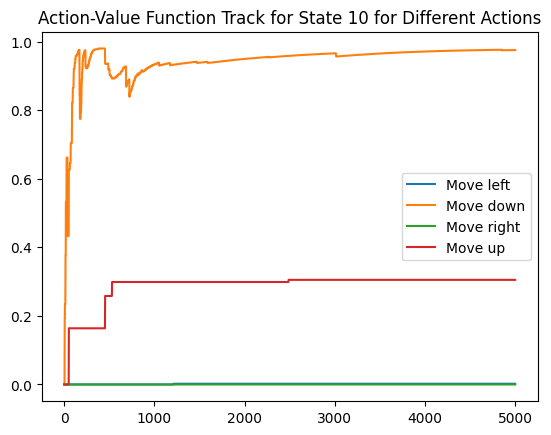

In [18]:
state = 10
plt.plot(action_value_function_track[:, state, :], label=label_to_action)
plt.title(f'Action-Value Function Track for State {state} for Different Actions')
plt.legend()

In [14]:
action_to_label

{0: 'Move left', 1: 'Move down', 2: 'Move right', 3: 'Move up'}

In [15]:
from tabulate import tabulate
import numpy as np

def draw_optimal_policy(Q):
    # Define the actions
    actions = ["<-", "v", ">", "^"]

    # Initialize the policy
    policy = {}

    # Iterate over each state in the Q table
    for s in range(Q.shape[0]):
        # Find the action with the highest value
        optimal_action_index = np.argmax(Q[s])
        optimal_action = actions[optimal_action_index]

        # Update the policy
        policy[s] = optimal_action

    # Reshape the policy into a 4x4 grid
    policy_grid = np.array(list(policy.values())).reshape(4, 4)

    # Create table data
    table_data = [list(row) for row in policy_grid]

    # Print the policy grid with tabulate
    print(tabulate(table_data, tablefmt="grid"))

    return policy

In [16]:
# Assuming action_value_function is your numpy ndarray

policy = draw_optimal_policy(action_value_function)


+----+----+---+----+
| >  | >  | v | <- |
+----+----+---+----+
| ^  | <- | v | <- |
+----+----+---+----+
| ^  | v  | v | <- |
+----+----+---+----+
| <- | >  | > | <- |
+----+----+---+----+


In [19]:
def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)

In [20]:
def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        while not done and steps < max_steps:
            state, _, done, h = env.step(pi(state))
            steps += 1
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100


In [ ]:
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

In [22]:
LEFT, DOWN, RIGHT, UP = range(4)

pi = lambda s: {
    0:LEFT,   1:UP,     2:UP,    3:UP,
    4:LEFT,   5:LEFT,   6:LEFT,  7:LEFT,
    8:UP,     9:DOWN,  10:LEFT, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}[s]

In [43]:
pi(1)

3